In [1]:
import pandas as pd
import numpy as np

Loading the data

In [2]:
data = pd.read_csv("data.csv")
raw_copy = data.copy()
data.head(10)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
5,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,31200
6,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,26,17,3916,44100
7,BMW,1 Series,2012,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,39300
8,BMW,1 Series,2012,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,36900
9,BMW,1 Series,2013,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,27,18,3916,37200


There are some parameters that require further inspection - the Market Category for example, might require splitting into several columns with something different than just trivial one-hot encoding.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

Not all values are also specified. 
Let's split the sets first.

In [4]:
from sklearn.model_selection import train_test_split

target = data["MSRP"]
data = data.drop(["MSRP"], axis = 1)


data_train, data_test, target_train, target_data  = train_test_split(data, target, test_size = 0.3)

In [5]:
data_train["Engine Fuel Type"].value_counts()

regular unleaded                                5020
premium unleaded (required)                     1390
premium unleaded (recommended)                  1087
flex-fuel (unleaded/E85)                         619
diesel                                           109
electric                                          52
flex-fuel (premium unleaded required/E85)         34
flex-fuel (premium unleaded recommended/E85)      18
flex-fuel (unleaded/natural gas)                   6
natural gas                                        2
Name: Engine Fuel Type, dtype: int64

There aren't many entries that correspond to flex-fuel, but they could be replaced with the recommended or required fuel for this category.

Also, electric and natural gas will be merged into one "other" category, since there aren't many examples of those cars, which might lead to poor results.

Also, by default, any unknown category will be encoded as other in the future.

Let's code this way of reasoning.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

fuelCategorySubstitution = {
    "electric" : "other",
    "flex-fuel (premium unleaded required/E85)" : "premium unleaded (required)",
    "flex-fuel (premium unleaded recommended/E85)" : "premium unleaded (recommended)",
    "flex-fuel (unleaded/natural gas)" : "other",
    "flex-fuel (unleaded/E85)" : "unleaded",
    "natural gas" : "other"
}

class LabelSwapper(BaseEstimator, TransformerMixin):
    def __init__(self, columnIndices, replacementDictionaries):
        self.columnIndices = columnIndices
        self.replacementDictionaries = replacementDictionaries
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        tr = X.copy()
        for columnNumerator, columnIndex in enumerate(self.columnIndices):
            for key,value in self.replacementDictionaries[columnNumerator].items():
                tr[tr[:,columnIndex]==key] = value
        return tr

class SimpleLabelSwapper(BaseEstimator, TransformerMixin):
    def __init__(self, dictionary):
        self.dictionary = dictionary
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        tr = X.copy()
        for _from, _to in self.dictionary.items():
            tr[tr==_from] = _to
        return tr
            

    
#let's see this in action

ls = LabelSwapper(
    [data_train.columns.get_loc("Engine Fuel Type")],
    [fuelCategorySubstitution]
)

pd.DataFrame(
    (ls.fit_transform(data_train.to_numpy()))[:,data_train.columns.get_loc("Engine Fuel Type")]
).value_counts()

regular unleaded                  5020
premium unleaded (required)       1424
premium unleaded (recommended)    1105
unleaded                           619
diesel                             109
other                               60
dtype: int64

Next, it is required to take care of the market category column, which requires some splitting. This will be an extended version of one-hot encoding.

In [7]:
data_train["Market Category"].value_counts()

Crossover                                          775
Luxury                                             604
Flex Fuel                                          600
Luxury,Performance                                 467
Hatchback                                          460
                                                  ... 
Crossover,Exotic,Luxury,Performance                  1
Performance,Hybrid                                   1
Exotic,Factory Tuner,Luxury,Performance              1
Crossover,Luxury,Performance,Hybrid                  1
Flex Fuel,Factory Tuner,Luxury,High-Performance      1
Name: Market Category, Length: 71, dtype: int64

In [8]:
import scipy #for sparse matrices

class FeatureExploder(BaseEstimator, TransformerMixin):
    def __init__(self, columnIndices):
        self.columnIndices = columnIndices
        if not len(columnIndices):
            print("Warning! ColumnIndices shouldn't be empty")
    def fit(self, X, y = None):
        self.dictionaries = [{} for _ in range(len(self.columnIndices))]
        
        for columnNumerator, columnIndex in enumerate(self.columnIndices):
            for cEntry in X[:,columnIndex]:
                if pd.isnull(cEntry):
                    continue
                for word in cEntry.split(","):
                    if word not in self.dictionaries[columnNumerator]:
                        self.dictionaries[columnNumerator][word] = len(self.dictionaries[columnNumerator])
        return self
    def transform(self, X):
        tr = X.copy()[:,:self.columnIndices[0]]
        for columnNumerator, columnIndex in enumerate(self.columnIndices):
            newA = np.zeros((X.shape[0], len(self.dictionaries[columnNumerator])))
            rowIdx = 0
            for cEntry in X[:,columnIndex]:
                if pd.isnull(cEntry):
                    continue
                for entry in cEntry.split(","):
                    if entry in self.dictionaries[columnNumerator]:
                        newA[rowIdx,self.dictionaries[columnNumerator][entry]] = 1
                rowIdx += 1
            if columnNumerator != len(self.columnIndices) -1:
                tr = np.c_[tr, newA, X[:,columnIndex+1:self.columnIndices[self.columnNumerator+1]]]
            else:
                tr = np.c_[tr, newA, X[:,columnIndex+1:]]
        return tr
    
fe = FeatureExploder(
    [data_train.columns.get_loc("Market Category")],
)

pd.set_option("display.max_columns", None)

pd.DataFrame(
    (fe.fit_transform(data_train.to_numpy()))
).sort_index()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,Ford,F-250,1999,regular unleaded,220.0,8.0,MANUAL,four wheel drive,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Large,Extended Cab Pickup,16,12,5657
1,Mazda,3,2017,regular unleaded,184.0,4.0,AUTOMATIC,front wheel drive,4.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Midsize,Sedan,36,27,586
2,Volkswagen,Jetta SportWagen,2014,regular unleaded,170.0,5.0,AUTOMATIC,front wheel drive,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Compact,Wagon,30,23,873
3,Nissan,Juke,2017,premium unleaded (required),215.0,4.0,MANUAL,front wheel drive,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Compact,4dr Hatchback,31,26,2009
4,Dodge,Ram Pickup 1500,2010,flex-fuel (unleaded/E85),310.0,8.0,AUTOMATIC,rear wheel drive,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Large,Regular Cab Pickup,19,14,1851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,Ferrari,458 Italia,2013,premium unleaded (required),562.0,8.0,AUTOMATED_MANUAL,rear wheel drive,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Compact,Convertible,17,13,2774
8335,Volkswagen,Beetle Convertible,2015,diesel,150.0,4.0,MANUAL,front wheel drive,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Compact,Convertible,40,30,873
8336,Ford,Escort,2002,regular unleaded,110.0,4.0,AUTOMATIC,front wheel drive,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Compact,Sedan,32,23,5657
8337,Mitsubishi,Outlander,2017,regular unleaded,166.0,4.0,AUTOMATIC,all wheel drive,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Midsize,4dr SUV,29,24,436


This encoding looks correct. However, it might be better to rephrase the code so it can be used with a column transformer.

In [157]:
class ColumnExploder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        self.dict = {}
        X  = X.to_numpy().reshape(-1,)
        for entry in X:
            if pd.isnull(entry):
                continue
            for word in entry.split(","):
                if word not in self.dict:
                    self.dict[word] = len(self.dict)
        return self
    def transform(self, X):
        X = X.to_numpy().reshape(-1,)
        res = scipy.sparse.lil_matrix((len(X), len(self.dict)))
        for idx, cEntry in enumerate(X):
            if pd.isnull(cEntry):
                continue
            for entry in cEntry.split(","):
                if entry in self.dict:
                    res[idx, self.dict[entry]] = 1
        return res
            

In [158]:
ce = ColumnExploder()

pd.set_option("display.max_columns", None)

(ce.fit_transform(data_train["Market Category"])).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Let's now display a histogram of numerical values.

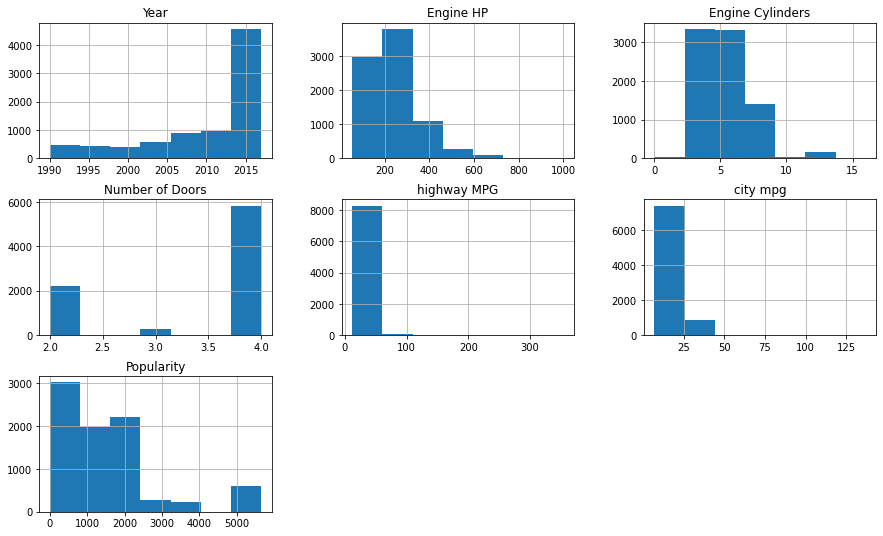

In [11]:
data_train.hist(bins = 7, figsize=(15, 9))
pass

Many values are skewed, for example Popularity or city mpg. For efficient training it might be useful to to transform them.

<AxesSubplot:>

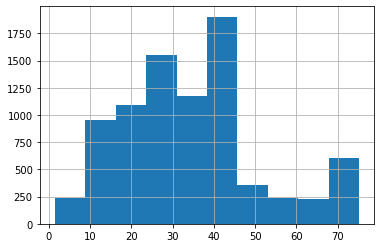

In [12]:
np.sqrt(data_train["Popularity"]).hist()

<AxesSubplot:>

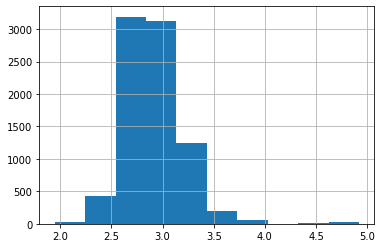

In [13]:
np.log(data_train["city mpg"]).hist()

<AxesSubplot:>

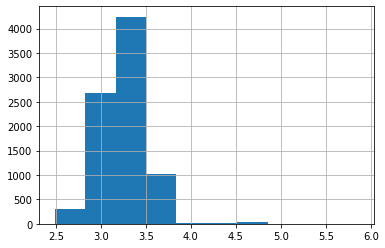

In [14]:
np.log(data_train["highway MPG"]).hist()

Also, number of doors could be categorised.
Let's look at the correlation matrix and then start building the transformer.

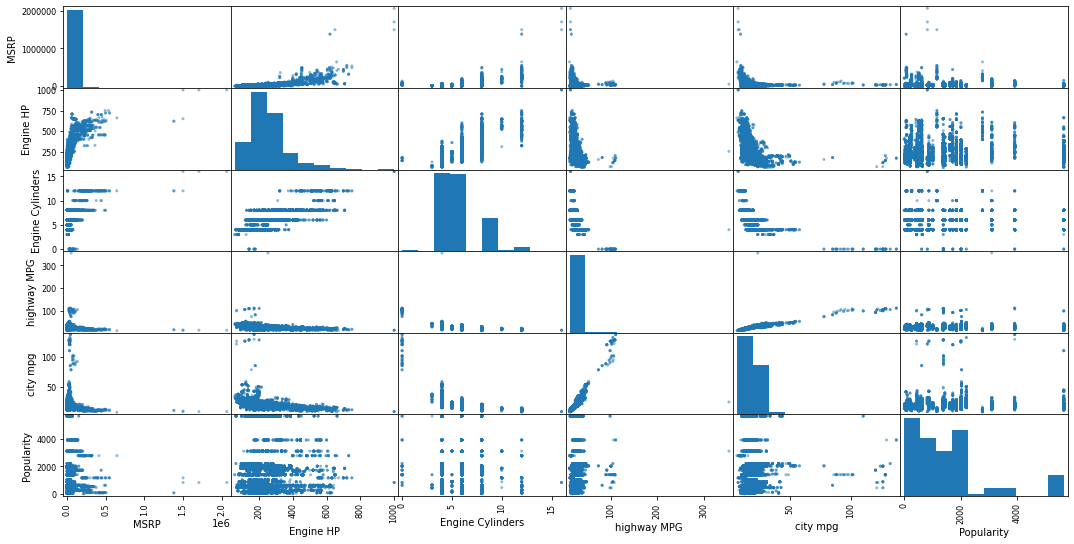

In [15]:
from pandas.plotting import scatter_matrix

scatter_matrix(raw_copy[["MSRP", "Engine HP", "Engine Cylinders", "highway MPG", "city mpg", "Popularity"]], 
              figsize=(18, 9))
pass

As can be seen, MSRP tends to depend mostly on Engine HP, also on number of cylinders, and somehow on city MPG, though it's not the best predictor.

In [153]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [245]:
numericalTransform = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

logTransform = Pipeline([
    ("log1p", FunctionTransformer(np.log1p)),
    ("numerical", numericalTransform)
])

sqrtTransform = Pipeline([
    ("sqrt", FunctionTransformer(np.sqrt)),
    ("numerical", numericalTransform)
])

replacedSwapper = Pipeline([
    ("replacing", SimpleLabelSwapper(fuelCategorySubstitution)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoding", OneHotEncoder(handle_unknown = 'ignore'))
])

categoricalEncoder = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(handle_unknown = 'ignore'))
])

I do not interpret number of doors as a numerical feature, since it might be more effective to use it as a category instead.

In [246]:
normalNumerical = ["Year", "Engine HP", "Engine Cylinders"]
logNumerical = ["city mpg", "highway MPG"]
sqrtNumerical = ["Popularity"]
simpleCategorical = ["Make", "Model", "Transmission Type", "Driven_Wheels", "Number of Doors", "Vehicle Size",
                    "Vehicle Style"]
explodedCategorical = ["Market Category"]
replacedCategorical = ["Engine Fuel Type"]

pipeline = ColumnTransformer([
    ("categorical", categoricalEncoder, simpleCategorical),
    ("explodedCategorical", ColumnExploder(), explodedCategorical),
    ("replacedCategorical", replacedSwapper, replacedCategorical),
    ("numerical", numericalTransform, normalNumerical),
    ("logNumerical", logTransform, logNumerical),
    ("sqrtNumerical", sqrtTransform, sqrtNumerical)
])

Seems to work well.

Now let's search for the best simple model to fit this data.

In [177]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [178]:
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR

In [179]:
train_preprocessed = pipeline.fit_transform(data_train)

In [180]:
linreg = Ridge()
linreg_params = {
    "alpha":np.linspace(1e-9, 10, 10)
}
search = RandomizedSearchCV(linreg, param_distributions=linreg_params,
                           cv = 3, scoring = "neg_mean_squared_error")
search.fit(train_preprocessed, target_train)
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))

21388.665415454645


In [182]:
svr = SVR()
svr_params = [
    {
        "kernel":["rbf"], "gamma" : ["scale", "auto"], "C" : np.linspace(1e-5, 10000, 8),
        "epsilon" : np.linspace(1e-5, 10, 5)
    },
    {
        "kernel":["linear"], "C" : np.logspace(1e-9, 10, 5)
    }
]
search = RandomizedSearchCV(svr, param_distributions=svr_params,
                           cv = 3 ,scoring="neg_mean_squared_error")
search.fit(train_preprocessed, target_train)
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))
search.best_estimator_

37114.4656564819


SVR(C=10000.0, epsilon=2.5000075)

In [185]:
rfr = RandomForestRegressor()
rfr_params = {
    "n_estimators" : np.linspace(10, 1000, 10, dtype=int),
    "max_depth" : np.linspace(3, 15, 10, dtype=int),
}
search = RandomizedSearchCV(rfr, param_distributions=rfr_params, n_jobs = 8,
                           cv = 3, scoring="neg_mean_squared_error")
search.fit(train_preprocessed, target_train)
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))

21104.818029650185


Let's explore the random forest regressor a bit more.

In [186]:
search.best_estimator_

RandomForestRegressor(max_depth=11, n_estimators=340)

In [187]:
rfr_params = {
    "n_estimators" : np.linspace(250, 500, 20, dtype = int),
    "max_depth" : np.linspace(8, 8+5, 5, dtype = int)
}
search = RandomizedSearchCV(rfr, param_distributions=rfr_params,
                           cv = 3, scoring="neg_mean_squared_error", n_jobs=8)
search.fit(train_preprocessed, target_train)
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))

20781.298094483995


In [188]:
search.best_estimator_

RandomForestRegressor(max_depth=11, n_estimators=250)

Not the best score. Let's look back at SVR.

In [198]:
svr = LinearSVR()
svr_params = [
    {
        "C" : np.linspace(1e-5, 1e5, 40),
        "epsilon" : np.linspace(1e-20, 1e-5, 40),
        "max_iter" : [15000]
    }
]
search = GridSearchCV(svr, svr_params,
                           cv = 3 ,scoring="neg_mean_squared_error", n_jobs=8)
search.fit(train_preprocessed, target_train)

/home/karolszustakowski/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


GridSearchCV(cv=3, estimator=LinearSVR(), n_jobs=8,
             param_grid=[{'C': array([1.00000000e-05, 2.56410257e+03, 5.12820514e+03, 7.69230770e+03,
       1.02564103e+04, 1.28205128e+04, 1.53846154e+04, 1.79487180e+04,
       2.05128205e+04, 2.30769231e+04, 2.56410256e+04, 2.82051282e+04,
       3.07692308e+04, 3.33333333e+04, 3.58974359e+04, 3.84615385e+04,
       4.10256410e+04, 4.35897436e+04, 4.61538...
       5.12820513e-06, 5.38461538e-06, 5.64102564e-06, 5.89743590e-06,
       6.15384615e-06, 6.41025641e-06, 6.66666667e-06, 6.92307692e-06,
       7.17948718e-06, 7.43589744e-06, 7.69230769e-06, 7.94871795e-06,
       8.20512821e-06, 8.46153846e-06, 8.71794872e-06, 8.97435897e-06,
       9.23076923e-06, 9.48717949e-06, 9.74358974e-06, 1.00000000e-05]),
                          'max_iter': [15000]}],
             scoring='neg_mean_squared_error')

In [200]:
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))
search.best_params_

29144.985038718543


{'C': 100000.0, 'epsilon': 4.102564102564109e-06, 'max_iter': 15000}

In [206]:
svr = LinearSVR()
svr_params = [
    {
        "C" : np.linspace(635019-50000, 619230+50000, 40),
        "epsilon" : np.linspace(3.96e-6-1e-6, 3.96e-6+1e-6, 20),
        "max_iter" : [15000]
    }
]
search = GridSearchCV(svr, svr_params,
                           cv = 3 ,scoring="neg_mean_squared_error", n_jobs=8)
search.fit(train_preprocessed, target_train)

GridSearchCV(cv=3, estimator=LinearSVR(), n_jobs=8,
             param_grid=[{'C': array([585019.        , 587178.25641026, 589337.51282051, 591496.76923077,
       593656.02564103, 595815.28205128, 597974.53846154, 600133.79487179,
       602293.05128205, 604452.30769231, 606611.56410256, 608770.82051282,
       610930.07692308, 613089.33333333, 615248.58974359, 617407.84615385,
       619567.1025641 , 621726.3589743...
                          'epsilon': array([2.96000000e-06, 3.06526316e-06, 3.17052632e-06, 3.27578947e-06,
       3.38105263e-06, 3.48631579e-06, 3.59157895e-06, 3.69684211e-06,
       3.80210526e-06, 3.90736842e-06, 4.01263158e-06, 4.11789474e-06,
       4.22315789e-06, 4.32842105e-06, 4.43368421e-06, 4.53894737e-06,
       4.64421053e-06, 4.74947368e-06, 4.85473684e-06, 4.96000000e-06]),
                          'max_iter': [15000]}],
             scoring='neg_mean_squared_error')

In [207]:
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))
search.best_params_

20687.070285854075


{'C': 621726.358974359, 'epsilon': 2.9600000000000005e-06, 'max_iter': 15000}

Let's get back to linear regression with polynomial features.

In [228]:
from sklearn.preprocessing import PolynomialFeatures

logPoly = Pipeline([
    ("log", logTransform),
    ("poly", PolynomialFeatures(2))
])

sqrtPoly = Pipeline([
    ("sqrt", sqrtTransform),
    ("poly", PolynomialFeatures(2))
])

numPoly = Pipeline([
    ("num", numericalTransform),
    ("poly", PolynomialFeatures(2))
])

pipeline = ColumnTransformer([
    ("categorical", OneHotEncoder(), simpleCategorical),
    ("explodedCategorical", ColumnExploder(), explodedCategorical),
    ("replacedCategorical", replacedSwapper, replacedCategorical),
    ("numerical", numPoly, normalNumerical),
    ("logNumerical", logPoly, logNumerical),
    ("sqrtNumerical", sqrtPoly, sqrtNumerical)
])

In [229]:
train_preprocessed_poly = pipeline.fit_transform(data_train)

In [230]:
linreg = Ridge()
linreg_params = {
    "alpha":np.linspace(1e-20, 1e5, 50)
}
search = GridSearchCV(linreg, linreg_params,
                           cv = 3, scoring = "neg_mean_squared_error")
search.fit(train_preprocessed_poly, target_train)
print(np.amin(np.sqrt(-search.cv_results_["mean_test_score"])))

21001.086028962567


In [231]:
search.best_estimator_

Ridge(alpha=1e-20)

This is probably as good as it gets. Lets train it with the SVM and evaluate on the test set for final result.

In [247]:
pipeline = ColumnTransformer([
    ("categorical", categoricalEncoder, simpleCategorical),
    ("explodedCategorical", ColumnExploder(), explodedCategorical),
    ("replacedCategorical", replacedSwapper, replacedCategorical),
    ("numerical", numericalTransform, normalNumerical),
    ("logNumerical", logTransform, logNumerical),
    ("sqrtNumerical", sqrtTransform, sqrtNumerical)
])

train_preprocessed = pipeline.fit_transform(data_train)

svr = LinearSVR(C = 621726, epsilon= 2.96e-06, max_iter=485000)
svr.fit(train_preprocessed, target_train)

LinearSVR(C=621726, epsilon=2.96e-06, max_iter=485000)

In [248]:
data_test_transformed = pipeline.transform(data_test)

In [250]:
predictions = svr.predict(data_test_transformed)

In [257]:
np.sqrt(np.sum(np.square(predictions - target_data))/len(predictions))

9043.803467965496

After training on the whole dataset the error seems to be much lower!
Perhaps, with a gaussian SVM it would be even better. For now, this result is satisfying.